In [1]:
from typing import Annotated, TypedDict, List, Any
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from langgraph.prebuilt import ToolNode, tools_condition
import gradio as gr
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
import os

In [2]:
load_dotenv(override=True)

True

-- Email Automation:

-- Tools:

-- 1. Check oreder status 

-- 2. Send email response in push notification

In [55]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    is_order_status_inquiry: bool

In [56]:
class ClassifyEmailOutput(BaseModel):
    is_order_status_inquiry: bool = Field(description="Whether the email is about order status inquiry or not")
    reasoning: str = Field(description="Reasoning for your answer")

In [ ]:
import json
import requests

def check_order_status(order_id: int) -> json:
    API_URL = f"{os.getenv("ORDERS_API_URL")}/{order_id}"
    headers = {
        "Content-Type": "application/json",
    }
    response = requests.get(API_URL, headers=headers)
    print(f"API Response Status Code: {response.status_code}")
    if response.status_code == 200:
        return f"Response fom check_order_status for {order_id} is {response.json()}"
    elif response.status_code == 404:
        return f"Response from check_order_status for {order_id} is not found"
    else:
        return f"Something went wrong while checking order status. Please try again later."

def send_push_notification(message: str) -> json:
    pushover_token = os.getenv("PUSHOVER_TOKEN")
    pushover_user = os.getenv("PUSHOVER_USER")
    API_URL = "https://api.pushover.net/1/messages.json"
    
    response = requests.post(
        API_URL, 
        data={
            "token": pushover_token, 
            "user": pushover_user, 
            "message": message
        }
    )
    print(f"API Response Status Code: {response.status_code}")
    return f"Response form send_push_notification: Push notification sent to the user"

def classify_email(email: str) -> json:
    system_message = """
    You are a customer service agent for a Elco Lighting company.
    You help customers with their orders and answer their questions.
    Your are given an customer email. By reading email you have to identify that if the email is about order status inquiry or not.
    For classifying email, email content should have questions or inquiry related to only order status not any other topic or order related topic.

    You must always provide final answer in json format only no other text or backticks.
    """
    messages = [SystemMessage(content=system_message), HumanMessage(content=email)]
    response = llm.with_structured_output(ClassifyEmailOutput).invoke(messages)
    return response.json()


In [58]:
from langchain.agents import Tool

tool_check_order_status = Tool(
    name="check_order_status",
    description="Check the status of an order by providing the order id",
    func=check_order_status
)

tool_send_push_notification = Tool(
    name="send_push_notification",
    description="Send a push notification to the user",
    func=send_push_notification
)

tool_classify_email = Tool(
    name="classify_email",
    description="Classify the email into order status inquiry or not",
    func=classify_email
)

In [59]:
tools = [tool_check_order_status, tool_send_push_notification]

In [60]:
tool_check_order_status.invoke("917149")

API Response Status Code: 200


"Response fom check_order_status for 917149 is {'order_number': '917149', 'po_number': '380079079', 'status': 'Ship Complete', 'customer': '3344'}"

In [61]:
tool_send_push_notification.invoke("Hello, this is a test push notification")

API Response Status Code: 200


'Response form send_push_notification: Push notification sent to the user'

In [62]:
tool_classify_email.invoke("Hi, I just wanted to know what is thee staus of my order? Best regards, Karan")

C:\Users\KaranJJoshi\AppData\Local\Temp\ipykernel_13512\3921324459.py:45: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  return response.json()


'{"is_order_status_inquiry":true,"reasoning":"The email contains a question about the order status."}'

In [63]:
llm = init_chat_model(
    model="google_genai:gemini-2.0-flash-lite"
)

In [64]:
def classifier(state: State) -> State:
    if state.get("is_order_status_inquiry"):
        return state
    response = tool_classify_email.invoke(state["messages"][-1].content)
    new_state = {
        "messages": [{"role": "assistant", "content": f"Response from classify_email: {response}"}],
        "is_order_status_inquiry": json.loads(response)["is_order_status_inquiry"]
    }
    return new_state
    

In [65]:
def agent(state: State) -> State:
    is_order_status_inquiry = state["is_order_status_inquiry"]
    user_email = state["messages"][-2]
    print(f"User email: {user_email}")
    if is_order_status_inquiry:
        system_message = f"""
        You are a customer service agent for a Elco Lighting company.
        Your are given an customer email and classification result.
        You have tools to check the order status and send push notification to the user.
        NOTE: If the user email ddoesn't contains order number please ask them for valid order number before proceed to check the order status.
        Make sure to complete task in following order:
        1. check_order_status (Only if email is related to order status inquiry)
        2. send_push_notification (Draft comprehensive response of response from check_order_status and send push notification to the user)
        After sending push notification, you just have to response with update what's done.
        """
    else:
        system_message = f"""
        You are a customer service agent for a Elco Lighting company.
        Your are given an customer email and classification result.
        But the email is not related to order status inquiry.
        You have to send a generic response to the user in a push notification. You have tool to send push notification to the user.
        After sending push notification, you just have to response with update what's done.
        """
    
    found_system_message = False
    messages = state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages
    
    # Invoke the LLM with tools
    response = llm.bind_tools(tools).invoke(messages)
    
    # Return updated state
    return {
        "messages": [response],
    }

In [66]:
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(State)

graph_builder.add_node("agent", agent)
graph_builder.add_node("classify_email", classifier)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_edge(START, "classify_email")
graph_builder.add_edge("classify_email", "agent")
graph_builder.add_conditional_edges("agent", tools_condition, "tools")
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("agent", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

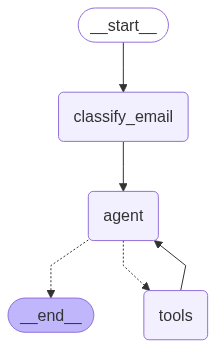

In [67]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "11"}}

async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7872
* To create a public link, set `share=True` in `launch()`.


C:\Users\KaranJJoshi\AppData\Local\Temp\ipykernel_13512\3921324459.py:45: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  return response.json()


User email: content="What's the status of my order?" additional_kwargs={} response_metadata={} id='b3309155-fc26-4c55-a9cc-91a130b99a35'
User email: content='\nI need your order number to check the status. Could you please provide it?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run--754af9fd-4360-41c7-86e0-8d9342686385-0' usage_metadata={'input_tokens': 240, 'output_tokens': 18, 'total_tokens': 258, 'input_token_details': {'cache_read': 0}}
API Response Status Code: 200
User email: content='' additional_kwargs={'function_call': {'name': 'check_order_status', 'arguments': '{"__arg1": "917149"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run--745398ac-bc16-4cd2-9020-ed475eb9cf08-0' tool_calls=[{'name': 'check_orde